In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import pickle
from pathlib import Path
import numpy as np
from jarvis.utils import tqdm

from hexarena import STORE_DIR
FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Overview of behavioral data

In [2]:
from hexarena.utils import get_valid_blocks

print("""
Counting blocks (N2/N1/N0) for different subject and conditions
N0: all blocks with enough valid data
N1: blocks also with position tracking
N2: blocks also with eye movement tracking
""")
subjects = ['marco', 'dylan', 'viktor']
pos_th, gaze_th = 0.5, 0.1
for gamma in [1, 10]:
    if gamma==1:
        print("Exponential schedule:")
    if gamma==10:
        print("Gamma (shape=10) schedule")

    for subject in subjects:
        block_infos = get_valid_blocks(subject, min_pos_ratio=0, min_gaze_ratio=0)
        pos_ratios, gaze_ratios, kappas, gammas = zip(*[
            (b['pos_ratio'], b['gaze_ratio'], b['kappa'], b['gamma']) for b in block_infos.values()
        ])
        pos_ratios = np.array(pos_ratios); gaze_ratios = np.array(gaze_ratios)
        kappas = np.array(kappas); gammas = np.array(gammas)
        for kappa in np.unique(kappas[gammas==gamma]):
            mask = (kappas==kappa)&(gammas==gamma)
            n0 = mask.sum().item()
            mask = mask&(pos_ratios>pos_th)
            n1 = mask.sum().item()
            mask = mask&(gaze_ratios>gaze_th)
            n2 = mask.sum().item()

            if kappa>0 and n0>=5:
                print("{} (kappa={}): {}/{}/{}".format(subject, kappa, n2, n1, n0))


Counting blocks (N2/N1/N0) for different subject and conditions
N0: all blocks with enough valid data
N1: blocks also with position tracking
N2: blocks also with eye movement tracking

Exponential schedule:
marco (kappa=0.01): 31/31/45
marco (kappa=0.1): 30/30/52
dylan (kappa=0.01): 0/6/55
dylan (kappa=0.04): 0/0/27
dylan (kappa=0.07): 0/0/20
dylan (kappa=0.1): 0/3/58
viktor (kappa=0.01): 0/0/96
viktor (kappa=0.1): 0/0/15
viktor (kappa=0.2): 0/0/81
Gamma (shape=10) schedule
viktor (kappa=0.02): 6/6/12
viktor (kappa=0.04): 7/7/11
viktor (kappa=0.08): 5/6/9
viktor (kappa=0.1): 7/7/14


## Push rates sorted by box quality

In [3]:
from hexarena.utils import load_monkey_data, align_monkey_data

push_rates = {}
for tag in [('marco', 1), ('dylan', 1), ('viktor', 1), ('viktor', 10)]:
    subject, gamma = tag
    if tag==('marco', 1):
        kappas = [0.01, 0.1]
    if tag==('dylan', 1):
        kappas = [0.01, 0.04, 0.07, 0.1]
    if tag==('viktor', 1):
        kappas = [0.01, 0.1, 0.2]
    if tag==('viktor', 10):
        kappas = [0.02, 0.04, 0.08, 0.1]
    
    block_infos = get_valid_blocks(subject, min_pos_ratio=0, min_gaze_ratio=0)
    push_rates[tag] = {}
    for kappa in kappas:
        push_rates[tag][kappa] = []
    for session_id, block_idx in tqdm(block_infos, desc=f'{subject} (gamma={gamma})', unit='block'):
        block_info = block_infos[(session_id, block_idx)]
        if block_info['gamma']!=gamma or block_info['kappa'] not in kappas:
            continue
        block_data = load_monkey_data(subject, session_id, block_idx)
        align_monkey_data(block_data)
        push_idx = block_data['push_idx']
        t = block_data['t'].max().item()
        push_rates[tag][block_info['kappa']].append(np.array([
            (push_idx==i).sum() for i in range(3)
        ])/t)
    for kappa in kappas:
        push_rates[tag][kappa] = np.stack(push_rates[tag][kappa])

marco (gamma=1):   0%|                                                                                        …

dylan (gamma=1):   0%|                                                                                        …

viktor (gamma=1):   0%|                                                                                       …

viktor (gamma=10):   0%|                                                                                      …

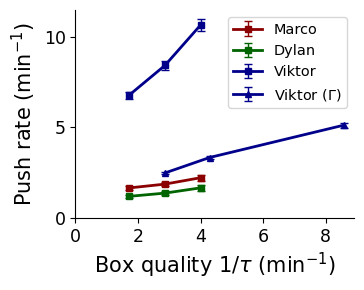

In [4]:
fig, ax = plt.subplots()
lines, legends = [], []
for tag in push_rates:
    subject, gamma = tag
    if subject=='marco':
        color = 'darkred'
    if subject=='dylan':
        color = 'darkgreen'
    if subject=='viktor':
        color = 'darkblue'
    if gamma==1:
        marker = 's'
        taus = np.array([35, 21, 15])
    if gamma==10:
        marker = '^'
        taus = np.array([21, 14, 7])

    vals = np.concat(list(push_rates[tag].values()))*60
    v_mean = vals.mean(axis=0)
    v_sem = vals.std(axis=0)/len(vals)**0.5
    lines.append(
        ax.errorbar(60/taus, v_mean, v_sem, color=color, elinewidth=1, capsize=3, marker=marker, markersize=4)
    )
    legends.append(subject.capitalize()+(r' ($\Gamma$)' if subject=='viktor' and gamma==10 else ''))
ax.set_xlim([0, None])
ax.set_xlabel(r'Box quality 1/$\tau$ (min$^{-1}$)')
ax.set_ylim([0, None])
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_ylabel(r'Push rate (min$^{-1}$)')
ax.legend(lines, legends, fontsize='x-small')
fig.savefig(FIG_DIR/'push.rate.overview.svg')

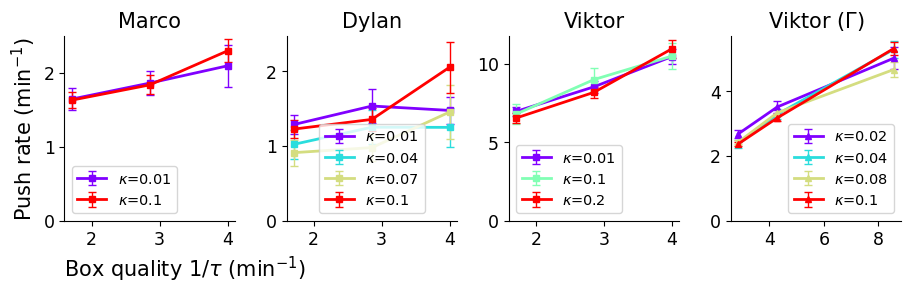

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(10.8, 2.4), gridspec_kw={'wspace': 0.3})
for ax, tag in zip(axes, push_rates):
    subject, gamma = tag
    if gamma==1:
        taus = np.array([35, 21, 15])
    if gamma==10:
        taus = np.array([21, 14, 7])
    lines = []
    kappas = sorted(push_rates[tag].keys())
    colors = mpl.colormaps['rainbow'](np.linspace(0, 1, len(kappas)))
    for i, kappa in enumerate(kappas):
        vals = push_rates[tag][kappa]*60
        v_mean = vals.mean(axis=0)
        v_sem = vals.std(axis=0)/len(vals)**0.5
        lines.append(
            ax.errorbar(
                60/taus, v_mean, v_sem, color=colors[i], elinewidth=1, capsize=3,
                marker='s' if gamma==1 else '^', markersize=4,
            )
        )
    ax.legend(lines, [r'$\kappa$='+'{:g}'.format(kappa) for kappa in kappas], fontsize='x-small')
    ax.set_title(f'{subject.capitalize()} (gamma={gamma})')
    ax.set_title(subject.capitalize()+(r' ($\Gamma$)' if subject=='viktor' and gamma==10 else ''))
    ax.set_ylim([0, None])
    ax.xaxis.get_major_locator().set_params(integer=True)
    ax.yaxis.get_major_locator().set_params(integer=True)
ax = axes[0]
ax.set_xlabel(r'Box quality 1/$\tau$ (min$^{-1}$)', loc='left')
ax.set_ylabel(r'Push rate (min$^{-1}$)')
fig.savefig(FIG_DIR/'push.rate.per.kappa.svg')

## Spatial occupancy

Only Marco's exponential schedule experiments and Viktor's Gamma schedule experiments have enough tracking data.

In [6]:
from hexarena.scripts.common import create_env

env = create_env(env_kw={'arena': {'resol': 4}})
n_tiles = env.arena.num_tiles

subject, gamma = 'viktor', 10
for subject, gamma in [('marco', 1), ('viktor', 10)]:
    save_pth = STORE_DIR/f'occupancy_{subject}.pkl'
    if os.path.exists(save_pth):
        continue
    block_infos = get_valid_blocks(subject, min_pos_ratio=0.05, min_gaze_ratio=0.05)
    pos_counts = np.zeros((2, env.arena.num_tiles), dtype=int)
    gaze_counts = np.zeros((2, env.arena.num_tiles), dtype=int)
    edges = np.arange(env.arena.num_tiles+1)-0.5
    for session_id, block_idx in tqdm(block_infos, unit='block'):
        if block_infos[(session_id, block_idx)]['gamma']==gamma:
            block_data = load_monkey_data(subject, session_id, block_idx)
            for i in range(2):
                if i==1:
                    align_monkey_data(block_data)
                env_data = env.convert_experiment_data(block_data)
                mask = np.concat([[True], env_data['push']<0])
                pos_counts[i] += np.histogram(env_data['pos'][mask], edges)[0]
                gaze_counts[i] += np.histogram(env_data['gaze'][mask], edges)[0]
    with open(save_pth, 'wb') as f:
        pickle.dump({
            'gamma': gamma, 'num_tiles': n_tiles,
            'pos_counts': pos_counts, 'gaze_counts': gaze_counts,
        }, f)

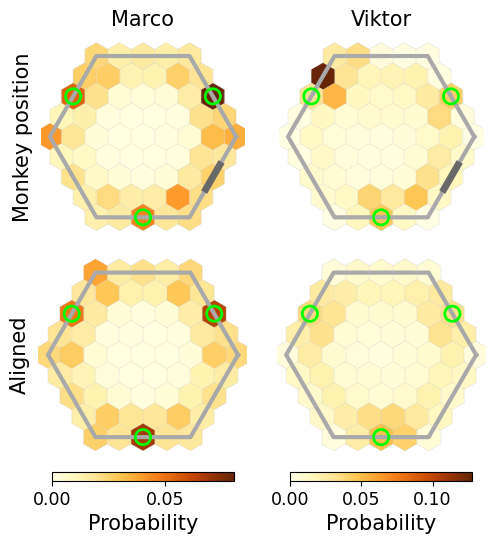

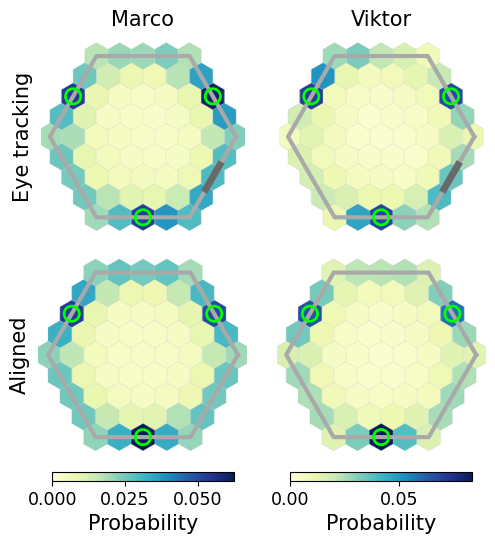

In [7]:
subjects = ['marco', 'viktor']

for k in range(2):
    if k==0:
        key = 'pos_counts'
        cmap = 'YlOrBr'
        label = 'Monkey position'
    if k==1:
        key = 'gaze_counts'
        cmap = 'YlGnBu'
        label = 'Eye tracking'
    fig, axes = plt.subplots(2, 2, figsize=(6, 6), height_ratios=[1, 1.2], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    for j, subject in enumerate(subjects):
        save_pth = STORE_DIR/f'occupancy_{subject}.pkl'
        with open(save_pth, 'rb') as f:
            saved = pickle.load(f)
        counts = saved[key]
        probs = counts/counts.sum(axis=-1, keepdims=True)
        vmax = probs.max()
        for i in range(2):
            ax = axes[i, j]
            env.arena.plot_map(
                ax, probs[i], vmax=vmax, door=i==0, cmap=cmap,
                cbar_kw={'label': 'Probability', 'disable': i==0},
            )
        axes[0, j].set_title(subject.capitalize())
    axes[0, 0].text(-1.4, 0, label, rotation='vertical', va='center')
    axes[1, 0].text(-1.4, 0, 'Aligned', rotation='vertical', va='center')
    fig.savefig(FIG_DIR/'occupancy_{}.svg'.format(key.split('_')[0]))

# Animation of one block

The best block of Marco is 20211202-01 (kappa=0.01), with 6.1 reward collected per minute


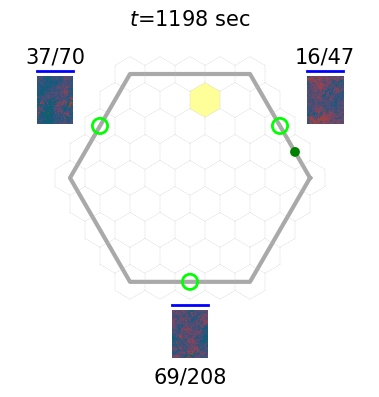

The worst block of Marco is 20211221-05 (kappa=0.01), with 0.7 reward collected per minute


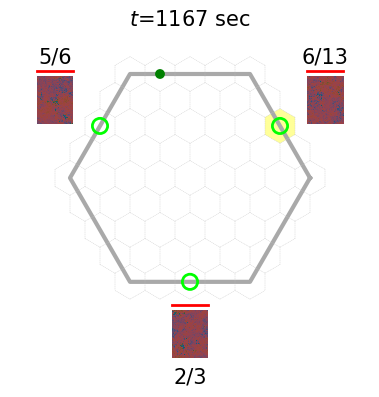

The best block of Viktor is 20230821-05 (kappa=0.1), with 10.6 reward collected per minute


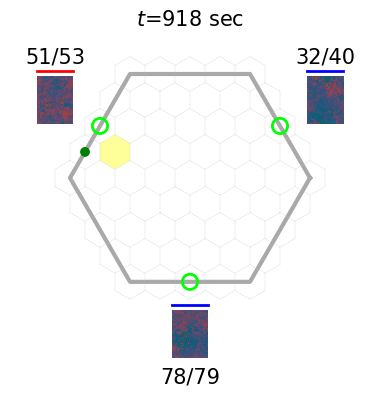

The worst block of Viktor is 20230809-06 (kappa=0), with 5.5 reward collected per minute


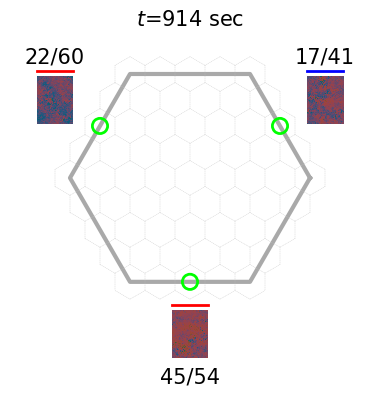

In [8]:
subjects = ['marco', 'viktor']

for subject in subjects:
    block_infos = get_valid_blocks(subject, min_pos_ratio=0.5, min_gaze_ratio=0.1)
    block_ids, reward_rates = [], []
    for block_id, block_info in block_infos.items():
        block_ids.append(block_id)
        reward_rates.append(block_info['reward']/block_info['duration'])
    block_ids, reward_rates = zip(*sorted(zip(block_ids, reward_rates), key=lambda x: x[1]))

    # create animation for the best and worst block
    for tag in ['best', 'worst']:
        if tag=='best':
            i = -1
        if tag=='worst':
            i = 0
        print('The {} block of {} is {}-{:02d} (kappa={:g}), with {:.1f} reward collected per minute'.format(
            tag, subject.capitalize(), *block_ids[i], block_infos[block_ids[i]]['kappa'], reward_rates[i]*60,
        ))
        block_data = load_monkey_data(subject, *block_ids[i])
        align_monkey_data(block_data)
        env_data = env.convert_experiment_data(block_data)
        fig, ani = env.play_episode(**env_data)
        savename = 'behavior_{}_[{}-{:02d}]'.format(subject, *block_ids[i])
        ani.save(FIG_DIR/f'{savename}.mp4', dpi=200, fps=12)
        fig.savefig(FIG_DIR/f'{savename}.svg')
        plt.show()